####  —— 何数学
# GCAE(带aspect嵌入的门控卷积网络) on ATSA
#### Gated Convolutional Network with Aspect Embedding
#### 参考《ACL2018：Aspect Based Sentiment Analysis with Gated Convolutional Networks》

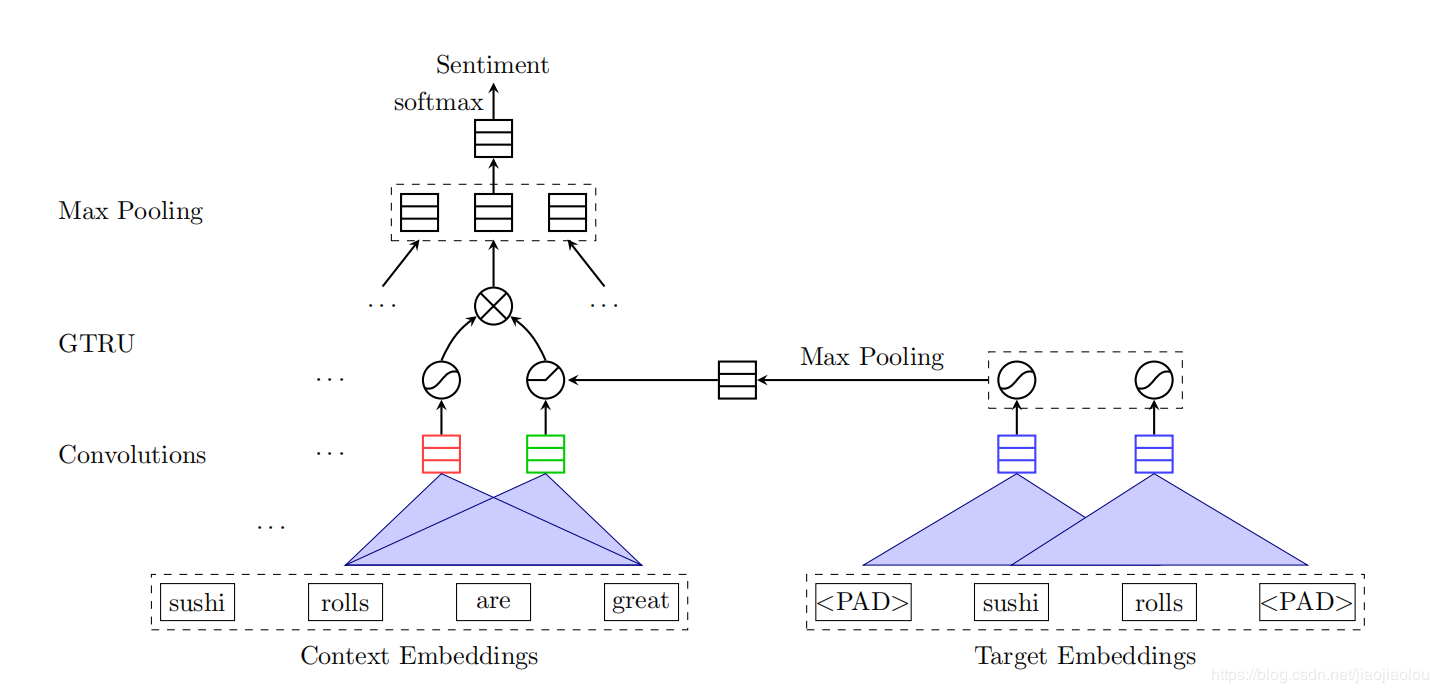

## Part1：word to vector
* **采用 glove 预训练好的词向量（包含标点，包含大小写的词语）。**

In [46]:
import os
import re
import sys
import numpy as np 
import torch
from torch.distributions import uniform

In [47]:
def load_glove(glove_path): 
    '''
    加载 glove 预训练好的词向量
    '''
    embed_index = {} # {'word':vectots,...}
    with open(glove_path, 'r', encoding = 'utf-8') as f:
        for line in f.readlines():
            line_sp = line.split(' ')
            word = line_sp[0] # 第一个元素为词
            embed_vector = torch.from_numpy(np.asarray(line_sp[1:], dtype='float32')) # [1:]为词向量
            embed_index[word] = embed_vector
    embed_dim = int(embed_vector.size()[0]) # 词向量的维数
    
    return embed_index, embed_dim

In [82]:
def embed_4_sen_asp(embed_index, embed_dim, sen_vocab, asp_vocab):
    '''
    句子词汇表与aspect词汇表的矩阵表示。
    
    输入：
    embedding_index：glove预训练好的词向量dict {'word':vectots,...}；
    embed_dim: 词向量维数；
    sen_vocab: 所有句子所含词语的词汇表；
    asp_vocab: aspect词汇表；
    
    输出：句子词汇表的矩阵表示；aspect词汇表的矩阵表示。其中每一行都为词汇表中一个词的词向量。
    '''
    sentence_embed = torch.zeros(len(sen_vocab), embed_dim) # 句子的矩阵表示初始化，每一行为句子词汇表中一个词的词向量
    i = 0
    for word in sen_vocab.keys(): # 因此句子embedding矩阵的每行词顺序同sen_vocab

        # 对于在glove中的词语，赋予该行glove中的词向量；否则赋予随机值
        sentence_embed[i,:] = embed_index[word] if word in embed_index else uniform.Uniform(-0.25,0.25).sample(torch.Size([embed_dim]))
        i += 1
    
    aspect_embed = torch.zeros(len(asp_vocab),embed_dim) # 同理，aspect的矩阵表示
    i = 0
    for word in asp_vocab.keys():
        aspect_embed[i,:] = embed_index[word] if word in embed_index else uniform.Uniform(-0.25,0.25).sample(torch.Size([embed_dim]))
        i += 1
        
    return sentence_embed, aspect_embed

## Part2：数据集加载
* **包括文本预处理：标点与词语分离网络搭建；去除 label 为“conflict”的样本。**

In [49]:
# import ast
# from ast import literal_eval
import pandas as pd

In [225]:
label_convert = {'negative':0,'positive':1,'neutral':2}

In [51]:
def preprocess(string):
    '''
    将标点与词语分离以便后续split。
    由load_data调用。
    '''
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()

In [52]:
def open_txt(datapath, txtname):
    '''
    打开 laptop-train.txt 与 laptop-test.txt 并转换为易用的dataframe，去除 label 为“conflict”的样本。
    由load_data调用。
    '''
    
    data = pd.DataFrame(columns=['id','text','aspect','label'])

    with open(datapath + txtname, 'r') as f:
        for line in f.readlines():
            line = line.strip('\n').split('\t')
            tmp_row = pd.Series({
                'id':line[0],
                'text':line[1],
                'aspect':line[2].split(':')[0],
                'label':line[3]
            })
            data = data.append(tmp_row,ignore_index=True)
            
    data = data.loc[ data['label'] != 'conflict' ] # 去除 label 为“conflict”的样本
        
    return data

In [53]:
# print('original label:',data.label.unique())
# data = data.loc[ data['label'] != 'conflict' ]
# print('current label:',data.label.unique())

In [176]:
def load_data(datapath):
    '''
    加载 laptop-train.txt 与 laptop-test.txt
    
    输入：存放 laptop-train.txt 与 laptop-test.txt 的路径
    输出：train与test分别的句子、aspect、情感标签的列表
    '''
    
    train_data = open_txt(datapath, '/laptop-train.txt')
    test_data = open_txt(datapath, '/laptop-test.txt')

    train_sentence =  list(train_data['text'].apply(lambda x : preprocess(x)))
    train_aspect = list(train_data['aspect'].apply(lambda x : preprocess(x)))
    train_sentiment = train_data['label'].map( label_convert )
    
    test_sentence =  list(test_data['text'].apply(lambda x : preprocess(x)))
    test_aspect = list(test_data['aspect'].apply(lambda x : preprocess(x)))
    test_sentiment = test_data['label'].map( label_convert  )
    
    return train_sentence,test_sentence,train_aspect,test_aspect,train_sentiment,test_sentiment


In [226]:
datapath = 'E:/0yanjiusheng/2AIML/Homework3'
train_corpus, test_corpus, train_aspect, test_aspect, train_labels, test_labels = load_data(datapath)

In [56]:
train_sent_len = [len(x.split(' ')) for x in list(traincorpus)]
print('训练集句子的最大词数为',max(train_sent_len))
test_sent_len = [len(x.split(' ')) for x in list(testcorpus)]
print('测试集句子的最大词数为',max(test_sent_len))

训练集句子的最大词数为 82
测试集句子的最大词数为 71


In [57]:
train_asp_len = [len(x.split(' ')) for x in list(train_aspect)]
print('训练集aspect的最大词数为',max(train_asp_len))
test_asp_len = [len(x.split(' ')) for x in list(test_aspect)]
print('测试集aspect的最大词数为',max(test_asp_len))

训练集aspect的最大词数为 7
测试集aspect的最大词数为 7


## Part3：词语与index转换、产生DataLoader

In [60]:
import collections
# from collections import Counter
from sklearn.model_selection import *
import torch.utils.data
from torch.utils.data import Dataset

In [61]:
sent_len = max(max(train_sent_len),max(test_sent_len)) # 训练集与测试集句子的最大词数
asp_len = max(max(train_asp_len),max(test_asp_len)) # 训练集与测试集aspect的最大词数
batchsize = 32

In [62]:
def get_vocab(data):
    '''
    输入所有句子的列表，输出其含有的所有词语的词汇表，并编号
    '''
    words = []
    for sentence in data:
        words += sentence.split() # 所有句子的词袋（词有重复）
    counts = list(set(words)) # 去重
    
    vocabulary = {}
    index = 0
    for word in counts:
        vocabulary[word] = index
        index += 1
    return vocabulary

In [78]:
def convert_indices(sentence, vocab, max_len):
    '''
    返回句子/aspect包含的（在词汇表中的）词语的index表示。返回值长度为句子/aspect的最大词数，不足之处从头开始用0填充。
    由get_indices调用。
    '''
    corpus_ind = [vocab[word] for word in sentence.split() if word in vocab] # 句子/aspect中的词在词汇表中的标号列表
    pad_ind = [0] * max_len # 最终的index表示长度为最大词数（pad是由于不足最大词数的部分用0填充）
    cur_len = len(corpus_ind) # 当前句子/aspect的长度
    pad_ind[max_len - cur_len:] = corpus_ind # 先是0，末尾是句子/aspect中词语的index表
    return torch.from_numpy(np.asarray(pad_ind,dtype='int32'))

In [64]:
def get_indices(data, vocab, max_len):
    '''
    返回整个语料库的index表示，每一行为一句话/一个aspect的index表示。
    '''
    indices = torch.zeros(len(data), max_len)
    for i in range(len(data)):
        indices[i] = convert_indices(data[i], vocab, max_len) # 每一行为一句话/一个aspect的index表示
    return indices

In [73]:
def generate_batches(train_sent, Xtest_sent, train_asp, Xtest_asp, train_1abel, ytest):
    '''
    训练集、验证集、测试集的loader
    '''
   
    # 将原训练数据分为训练集与验证集
    Xtrain_sent, Xval_sent, Xtrain_asp, Xval_asp, ytrain, yval = train_test_split(train_sent, train_asp, train_1abel,
                                                                                 test_size = 0.1, random_state = 0)
    # 训练集的句子、aspect词汇表
    sent_vocab = get_vocab(Xtrain_sent)
    asp_vocab = get_vocab(Xtrain_asp)
    
    # 训练集的句子语料库、aspect语料库的词语的index表示
    train_sent_ind = get_indices(Xtrain_sent, sent_vocab, sent_len)
    train_asp_ind = get_indices(Xtrain_asp, asp_vocab, asp_len)
    
    # 验证集的句子语料库、aspect语料库的词语的index表示
    val_sent_ind = get_indices(Xval_sent,sent_vocab,sent_len)
    val_asp_ind = get_indices(Xval_asp,asp_vocab,asp_len)
    
    # 测试集的句子语料库、aspect语料库的词语的index表示
    test_sent_ind = get_indices(Xtest_sent,sent_vocab,sent_len)
    test_asp_ind = get_indices(Xtest_asp,asp_vocab,asp_len)
    
    # 训练集、验证集、测试集的label
    ytrain = torch.from_numpy(np.asarray(ytrain,'int32'))
    yval = torch.from_numpy(np.asarray(yval,'int32'))
    ytest = torch.from_numpy(np.asarray(ytest,'int32'))
    
    # 训练集、验证集、测试集的loader
    train_array = torch.utils.data.TensorDataset(train_sent_ind, train_asp_ind, ytrain)
    train_loader = torch.utils.data.DataLoader(train_array,batchsize)
    
    val_array = torch.utils.data.TensorDataset(val_sent_ind,val_asp_ind,yval)
    val_loader = torch.utils.data.DataLoader(val_array,batchsize)
    
    test_array = torch.utils.data.TensorDataset(test_sent_ind,test_asp_ind,ytest)
    test_loader = torch.utils.data.DataLoader(test_array,batchsize)
    
    return train_loader,val_loader,test_loader,sent_vocab,asp_vocab

## Part4：网络搭建
* **论文核心部分：**
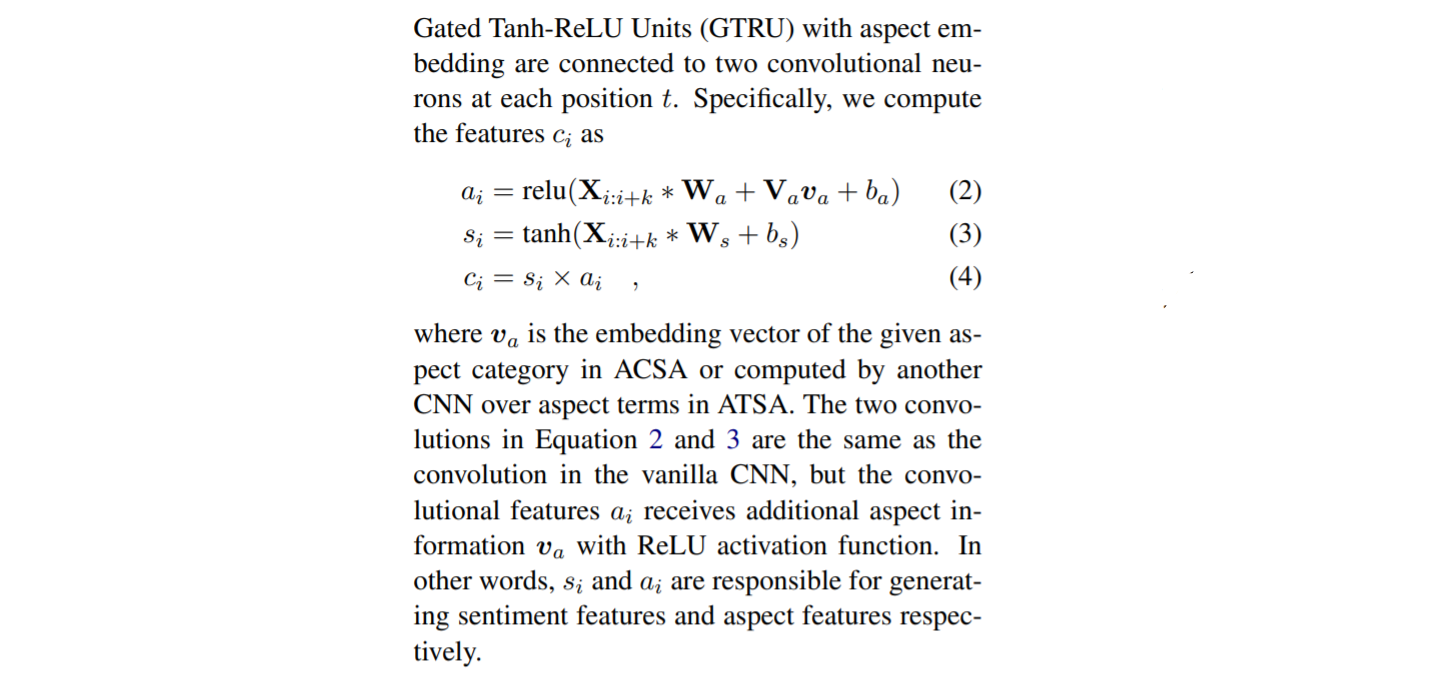

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [168]:
class GatedCNN(nn.Module):
    def __init__(self, sent_embed, asp_embed, embed_dim, num_class):
        super(GatedCNN, self).__init__()
        
        C = num_class # 情感类别数
        filters = 100 # 每种宽度的卷积核100个
        D = embed_dim # 词向量维数
        Ks = [3, 4, 5] # n-gram的n，即对于句子矩阵的卷积核的宽度有三种，分别3，4，5
        Ka = [3] # n-gram的n，即对于aspect矩阵的卷积核的宽度为3
        
        self.sent_embed = nn.Embedding.from_pretrained(sent_embed, freeze = True) # 词向量不参与训练
        self.asp_embed = nn.Embedding.from_pretrained(asp_embed, freeze = True)
        
        # aspect的卷积
        self.conv_asp1 = nn.Conv1d(D, filters, Ka[0], padding = Ka[0]-2)
        
        # 句子的卷积（三种宽度的核）
        self.conv_sen1 = nn.Conv1d(D, filters, Ks[0])
        self.conv_sen2 = nn.Conv1d(D, filters, Ks[1])        
        self.conv_sen3 = nn.Conv1d(D, filters, Ks[2])        
        
        # 句子+aspect的卷积（三种宽度的核）
        self.conv_senasp1 = nn.Conv1d(D,filters,Ks[0])
        self.conv_senasp2 = nn.Conv1d(D,filters,Ks[1])
        self.conv_senasp3 = nn.Conv1d(D,filters,Ks[2])
        
        # Aspect的全连接，用在与句子结合时
        self.fc_aspect = nn.Linear(filters, filters)
        
        # 激活函数（一个ReLU，一个Tanh）
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
        # 最终的全连接
        self.fc1 = nn.Linear(len(Ks)*filters, C)
        
    def forward(self, sent, asp):
        sentence_embed_t = self.sent_embed(sent).transpose(1,2)
        aspect_embed_t = self.asp_embed(asp).transpose(1,2)
        
        # aspect 的卷积、ReLU激活与最大池化
        out_asp = self.act1(self.conv_asp1(aspect_embed_t))
        out_asp = F.max_pool1d(out_asp, out_asp.size(2)).squeeze(2)
        
        # 句子的卷积、Tanh激活与最大池化
        out1_sen1 = self.act2(self.conv_sen1(sentence_embed_t))
        out1_sen2 = self.act2(self.conv_sen2(sentence_embed_t))
        out1_sen3 = self.act2(self.conv_sen3(sentence_embed_t))
        
        # 句子与aspect结合
        asp_ful = self.fc_aspect(out_asp).unsqueeze(2)
        out2_sen1 = self.act1((self.conv_senasp1(sentence_embed_t))+asp_ful)
        out2_sen2 = self.act1((self.conv_senasp2(sentence_embed_t))+asp_ful)
        out2_sen3 = self.act1((self.conv_senasp3(sentence_embed_t))+asp_ful)
        out_comb1 = out1_sen1 * out2_sen1
        out_comb2 = out1_sen2 * out2_sen2
        out_comb3 = out1_sen3 * out2_sen3    
        out_comb1 = F.max_pool1d(out_comb1,out_comb1.size(2)).squeeze(2)
        out_comb2 = F.max_pool1d(out_comb2,out_comb2.size(2)).squeeze(2)
        out_comb3 = F.max_pool1d(out_comb3,out_comb3.size(2)).squeeze(2)
        
        # 最终的dropout与全连接
        out = torch.cat([out_comb1,out_comb2,out_comb3],dim=1)
        out = self.dropout(out)  
        out = self.fc1(out)
        
        return out        

## Part5：定义模型训练过程与检测

In [288]:
import time
import copy
from copy import deepcopy
import torch.optim as optim
import time

In [ ]:
def evaluate(loader, net, device, save_pred = False):
    '''
    loss与准确度监测。
    '''
    with torch.no_grad():
        net.eval()
        loss = 0.0
        total = 0.0
        pred_saved = []
        n_correct = 0
        label_all = None
        
        for sent, asp, label in loader:
            sent = sent.long().to(device)
            asp = asp.long().to(device)
            label = label.long().to(device)
            
            out = net(sent, asp) # 网络输出
            cur_loss = F.cross_entropy(out, label, reduction = 'sum') # 当前单次loss
            loss += cur_loss.item() # 总loss
            pred = torch.max(out, 1)[1] # 预测值
            n_correct += torch.sum(pred == label.data).item() # 判断正确个数
            total += sent.size(0) # 句子数量
    
            if label_all is None: 
                label_all = label.data
                pred_all = pred
            else:                
                label_all = torch.cat((label_all, label.data), dim = 0)
                pred_all = torch.cat((pred_all, pred), dim = 0)
                
        acc = n_correct/total
        f1 = metrics.f1_score(label_all, pred_all, labels=[0, 1, 2], average='macro')
        
        if save_pred == True: # 保存预测值
            return loss/total, acc, f1, [int(x) for x in list(pred_all)]
        else:
            return loss/total, acc, f1

In [367]:
def train_model(train_loader, val_loader, test_loader, 
               sent_embed, asp_embed, embed_dim, num_class, device, runs, num_epochs = 15):
    '''
    runs: run多次，每次都是重新训网络，最终取测试集上的均值，即函数输出。
    '''
    
    avg_test_acc = 0.0
    avg_test_f1 = 0.0
#     num_epochs = 15 # 一次run中的epoch数
    test_best = 0
    
    val_loss_list = []
    val_acc_list = [] # 每个epoch的验证集acc变化
    val_f1_list = [] # 每个epoch的验证集f1变化
    
    for run in range(1, runs+1): # run多次，每次都是重新训网络
        
        print('第{}轮 run '.format(run))
        print('-' * 60)

        time_start=time.time()
        gated_cnn = GatedCNN(sent_embed, asp_embed, embed_dim, num_class).to(device)
        optimizer = torch.optim.Adagrad(gated_cnn.parameters(), lr=0.001)
        
        gated_cnn.train() 
        val_best = np.Inf # 存在在验证集上达到的最高精度
        best_model_wts = copy.deepcopy(gated_cnn.state_dict()) # 存放在验证集上精度最高的模型
        
        for epoch in range(1, num_epochs+1): 
            gated_cnn.train()
            for sent, asp, label in train_loader: # 训练
                sent = sent.long().to(device)
                asp = asp.long().to(device)
                label = label.long().to(device)
                
                optimizer.zero_grad()
                
                output = gated_cnn(sent, asp)
                loss = F.cross_entropy(output,label)
                loss.backward()
                optimizer.step()
        
            val_loss, val_acc, val_f1 = evaluate(val_loader, gated_cnn, device)
            val_loss_list.append(val_loss.item())
            val_acc_list.append(val_acc)
            val_f1_list.append(val_f1)
            
            if val_loss < val_best: # 更新在验证集上精度最高的模型
                val_best = val_loss
                best_model_wts = copy.deepcopy(gated_cnn.state_dict())
                
            print('Epoch {}: 验证集loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(epoch,val_loss,val_acc, val_f1))
            
            gated_cnn.load_state_dict(best_model_wts) # 保存在验证集上精度最高的模型
            
        # 该次runs中最好的model在测试集上的结果
        cur_test_loss, cur_test_acc, cur_test_f1, pred_saved = evaluate(test_loader, gated_cnn, device, save_pred = True)
        print('-' * 60)
        print("Run {}: 测试集 accuracy {:.4f}, f1 {:.4f}".format(run, cur_test_acc, cur_test_f1))
        time_end=time.time()
        print('耗时：',round(time_end-time_start,2),'s')
        print('=' * 60)
        
        avg_test_acc += cur_test_acc
        avg_test_f1 += cur_test_f1
        
        if cur_test_acc > test_best:
            test_best = cur_test_acc
            best_model_final = copy.deepcopy(gated_cnn.state_dict()) 
            best_pred = pred_saved
            val_loss_list = val_loss_list[-num_epochs :] # 只保存最好的训练结果，若超越，则只保存这次的结果
            val_acc_list = val_acc_list[-num_epochs :] 
            val_f1_list = val_f1_list[-num_epochs :]
        else: # 只保存最好的训练结果，若没有超越，则清空这次的结果
            val_loss_list = val_loss_list[: num_epochs]
            val_acc_list = val_acc_list[: num_epochs] 
            val_f1_list = val_f1_list[: num_epochs]
        
    return avg_test_acc/runs,avg_test_f1/runs, best_pred, val_loss_list, val_acc_list, val_f1_list  
    # 所有runs在测试集上的准确度均值，最好的一次run保存预测结果

## Part6：运行网络并输出指标与测试集预测结果

In [69]:
import argparse
import random
from sklearn.model_selection import *
from sklearn import metrics

In [236]:
np.random.seed(1332)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [79]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('-ru','--runs',type=int,help='number of runs',default=5)
    
    args, unknown = parser.parse_known_args()

    runs = args.runs

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device = torch.device('cpu') # 若使用GPU存在各种包之间版本的矛盾的话，可先使用CPU
    
    num_class = 3
    
    train_loader,val_loader,test_loader,sent_vocab,asp_vocab = generate_batches(train_corpus,test_corpus,
                                                                                train_aspect,test_aspect,
                                                                                train_labels,test_labels)
    glovepath = 'E:/0yanjiusheng/2AIML/Homework3/glove.840B.300d.txt' # glove存放位置
    # glove 预训练好的词向量下载地址：https://nlp.stanford.edu/projects/glove/

    embed_index, embed_dim = load_glove(glovepath)
    sentence_embed,aspect_embed = embed_4_sen_asp(embed_index, embed_dim, sent_vocab, asp_vocab)
    gated_cnn = GatedCNN(sentence_embed, aspect_embed, embed_dim, num_class).to(device)

In [368]:
test_acc, test_f1, prediction, val_loss_list, val_acc_list, val_f1_list = train_model(train_loader,val_loader,test_loader,
                                                                                      sentence_embed,aspect_embed,embed_dim,
                                                                                      num_class,device,10)

第1轮 run 
------------------------------------------------------------
Epoch 1: 验证集loss: 0.0304, accuracy: 0.6681, f1: 0.6331
Epoch 2: 验证集loss: 0.0265, accuracy: 0.7026, f1: 0.6629
Epoch 3: 验证集loss: 0.0253, accuracy: 0.6983, f1: 0.6548
Epoch 4: 验证集loss: 0.0249, accuracy: 0.7069, f1: 0.6593
Epoch 5: 验证集loss: 0.0253, accuracy: 0.7112, f1: 0.6668
Epoch 6: 验证集loss: 0.0252, accuracy: 0.7112, f1: 0.6668
Epoch 7: 验证集loss: 0.0252, accuracy: 0.7155, f1: 0.6707
Epoch 8: 验证集loss: 0.0251, accuracy: 0.7069, f1: 0.6593
Epoch 9: 验证集loss: 0.0252, accuracy: 0.7112, f1: 0.6668
Epoch 10: 验证集loss: 0.0251, accuracy: 0.7069, f1: 0.6593
Epoch 11: 验证集loss: 0.0251, accuracy: 0.7069, f1: 0.6593
Epoch 12: 验证集loss: 0.0251, accuracy: 0.7069, f1: 0.6593
Epoch 13: 验证集loss: 0.0248, accuracy: 0.7069, f1: 0.6593
Epoch 14: 验证集loss: 0.0251, accuracy: 0.7155, f1: 0.6707
Epoch 15: 验证集loss: 0.0253, accuracy: 0.7112, f1: 0.6668
------------------------------------------------------------
Run 1: 测试集 accuracy 0.6317, f1 0.5175


In [293]:
print("测试集平均acc: {:.4f}, 平均f1: {:.4f}".format(test_acc, test_f1))

测试集平均acc: 0.6415, 平均f1: 0.5314


### 可视化训练过程：

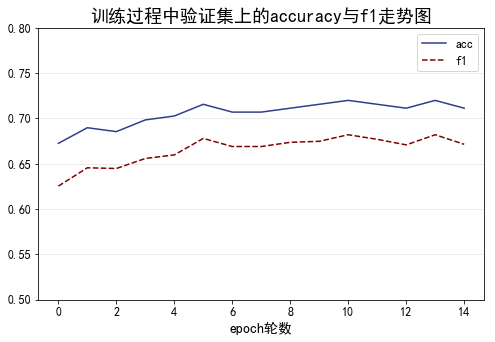

In [370]:
import matplotlib.pyplot as plt

# 解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#画图
plt.figure(num=3,figsize=(8,5))
plt.plot(range(15) ,val_acc_list,color='#2D3D8E',label='acc')
plt.plot(range(15) ,val_f1_list,color='#800000',linewidth=1.5,linestyle='--',label='f1')
plt.xlabel('epoch轮数',fontsize=14)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.ylim(0.5,0.8)
plt.legend(prop={'size': 12})
plt.title('训练过程中验证集上的accuracy与f1走势图',fontsize=18)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 保存结果：

In [369]:
final_pred = pd.Series(prediction).map({0:'negative', 1:'positive', 2:'neutral'} )
final_pred.to_csv('E:/0yanjiusheng/2AIML/Homework3/result_cnn.txt',index = False, header = False)

## * Part x：实验 - 是否可以通过集成模型来提高准确度
* **由于GCAE收敛速度快且不是非常稳定，是否可以减少每轮epoch数、增加run数，最终集成每次run的预测结果来提高精度。**

In [341]:
def train_model(train_loader, val_loader, test_loader, 
               sent_embed, asp_embed, embed_dim, num_class, device, runs = 30, num_epochs = 3):
    '''
    实验：对原来的train_model稍加改动，num_epochs改为3，runs增加至30。
    保存每轮run的预测结果，最终集成。
    '''  
    avg_test_acc = 0.0
    avg_test_f1 = 0.0
#     num_epochs = 15 # 一次run中的epoch数
    test_best = 0
    
    val_loss_list = []
    val_acc_list = [] # 每个epoch的验证集acc变化
    val_f1_list = [] # 每个epoch的验证集f1变化
    
    pred_all_runs = - np.ones((len(test_labels), runs)) # 【存放每个run的预测结果】
    
    for run in range(1, runs+1): # run多次，每次都是重新训网络
        
        print('第{}轮 run '.format(run))
        print('-' * 60)

        time_start=time.time()
        gated_cnn = GatedCNN(sent_embed, asp_embed, embed_dim, num_class).to(device)
        optimizer = torch.optim.Adagrad(gated_cnn.parameters(), lr=0.001)
        
        gated_cnn.train() 
        val_best = np.Inf # 存在在验证集上达到的最高精度
        best_model_wts = copy.deepcopy(gated_cnn.state_dict()) # 存放在验证集上精度最高的模型
        
        for epoch in range(1, num_epochs+1): 
            gated_cnn.train()
            for sent, asp, label in train_loader: # 训练
                sent = sent.long().to(device)
                asp = asp.long().to(device)
                label = label.long().to(device)
                
                optimizer.zero_grad()
                
                output = gated_cnn(sent, asp)
                loss = F.cross_entropy(output,label)
                loss.backward()
                optimizer.step()
        
            val_loss, val_acc, val_f1 = evaluate(val_loader, gated_cnn, device)
            val_loss_list.append(val_loss.item())
            val_acc_list.append(val_acc)
            val_f1_list.append(val_f1)
            
            if val_loss < val_best: # 更新在验证集上精度最高的模型
                val_best = val_loss
                best_model_wts = copy.deepcopy(gated_cnn.state_dict())
                
            print('Epoch {}: 验证集loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(epoch,val_loss,val_acc, val_f1))
            
            gated_cnn.load_state_dict(best_model_wts) # 保存在验证集上精度最高的模型
            
        # 该次runs中最好的model在测试集上的结果
        cur_test_loss, cur_test_acc, cur_test_f1, pred_saved = evaluate(test_loader, gated_cnn, device, save_pred = True)
#         print(np.asarray(pred_saved))
        pred_all_runs[:, run-1] = np.asarray(pred_saved)
        print('-' * 60)
        print("Run {}: 测试集 accuracy {:.4f}, f1 {:.4f}".format(run, cur_test_acc, cur_test_f1))
        time_end=time.time()
        print('耗时：',round(time_end-time_start,2),'s')
        print('=' * 60)
        
        avg_test_acc += cur_test_acc
        avg_test_f1 += cur_test_f1
        
        if cur_test_acc > test_best:
            test_best = cur_test_acc
            best_model_final = copy.deepcopy(gated_cnn.state_dict()) 
            best_pred = pred_saved
            val_loss_list = val_loss_list[-num_epochs :] # 只保存最好的训练结果，若超越，则只保存这次的结果
            val_acc_list = val_acc_list[-num_epochs :] 
            val_f1_list = val_f1_list[-num_epochs :]
        else: # 只保存最好的训练结果，若没有超越，则清空这次的结果
            val_loss_list = val_loss_list[: num_epochs]
            val_acc_list = val_acc_list[: num_epochs] 
            val_f1_list = val_f1_list[: num_epochs]
        
    return avg_test_acc/runs,avg_test_f1/runs, best_pred, val_loss_list, val_acc_list, val_f1_list, pred_all_runs 
    # 所有runs在测试集上的准确度均值，最好的一次run保存预测结果

In [344]:
test_acc, test_f1, prediction, val_loss_list, val_acc_list, val_f1_list, pred_all_runs = train_model(train_loader,val_loader,
                                                                                                     test_loader,sentence_embed,
                                                                                                     aspect_embed,embed_dim,
                                                                                                     num_class,device,
                                                                                                    30, 3)

第1轮 run 
------------------------------------------------------------
Epoch 1: 验证集loss: 0.0309, accuracy: 0.5819, f1: 0.5686
Epoch 2: 验证集loss: 0.0250, accuracy: 0.6940, f1: 0.6549
Epoch 3: 验证集loss: 0.0234, accuracy: 0.6940, f1: 0.6483
------------------------------------------------------------
Run 1: 测试集 accuracy 0.6238, f1 0.5068
耗时： 46.37 s
第2轮 run 
------------------------------------------------------------
Epoch 1: 验证集loss: 0.0309, accuracy: 0.6293, f1: 0.6104
Epoch 2: 验证集loss: 0.0250, accuracy: 0.6724, f1: 0.6223
Epoch 3: 验证集loss: 0.0234, accuracy: 0.6810, f1: 0.6338
------------------------------------------------------------
Run 2: 测试集 accuracy 0.6207, f1 0.5124
耗时： 47.43 s
第3轮 run 
------------------------------------------------------------
Epoch 1: 验证集loss: 0.0292, accuracy: 0.6595, f1: 0.6235
Epoch 2: 验证集loss: 0.0255, accuracy: 0.6897, f1: 0.6573
Epoch 3: 验证集loss: 0.0238, accuracy: 0.6940, f1: 0.6548
------------------------------------------------------------
Run 3: 测试集 a

In [357]:
# 30轮run的投票结果
ensemble_pred = pd.DataFrame(pred_all_runs).apply(lambda x: Counter(x).most_common(1)[0][0], axis = 1)

In [358]:
# 集成结果的acc
metrics.accuracy_score(test_labels, ensemble_pred)

0.6394984326018809

In [365]:
# 集成结果的f1
metrics.f1_score(test_labels, ensemble_pred, labels = [0,1,2],average='macro')

0.5380081452423653

### 并没有提高。